# FraudShield – Credit Card Fraud Detection System

In [1]:
# Import the libraries
import numpy as np
import pandas as pd

# Importing visualization libraries
import matplotlib.pyplot as plt

# Model & metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  



## 1.  Data Acquisition & Loading

In [2]:
# Load dataset  and create a dataframe
df = pd.read_csv("creditcard.csv")


In [3]:
print("First five rows of the dataset:")
df.head(5)

First five rows of the dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print("\nMissing values:\n", df.isna().sum())



Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [5]:
print("\nClass distribution:\n", df['Class'].value_counts())


Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [6]:
print("Dimensions of the data frame:", df.shape)

Dimensions of the data frame: (284807, 31)


In [7]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

## 2. Exploratory Data Analysis (EDA)

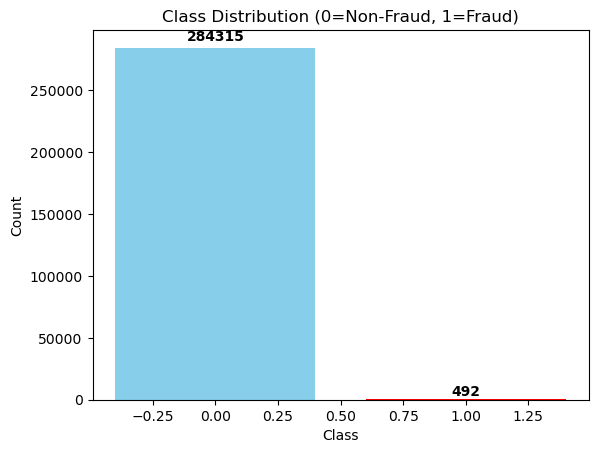

In [8]:
# Class distribution 
class_counts = df['Class'].value_counts().sort_index()

plt.bar(class_counts.index, class_counts.values, color=['skyblue','red'])
plt.title("Class Distribution (0=Non-Fraud, 1=Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")

for i, v in enumerate(class_counts.values):
    plt.text(i, v + (0.01 * v), str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()


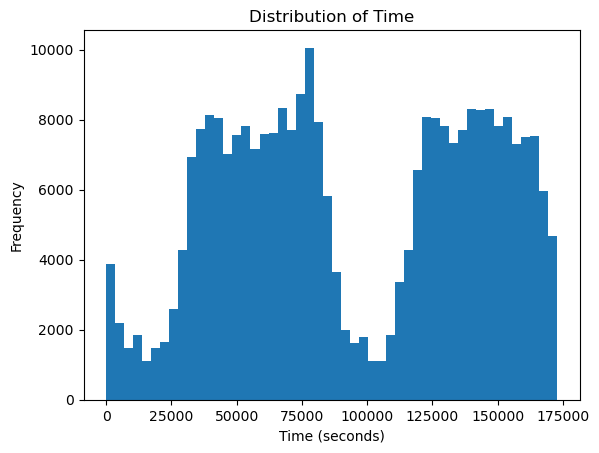

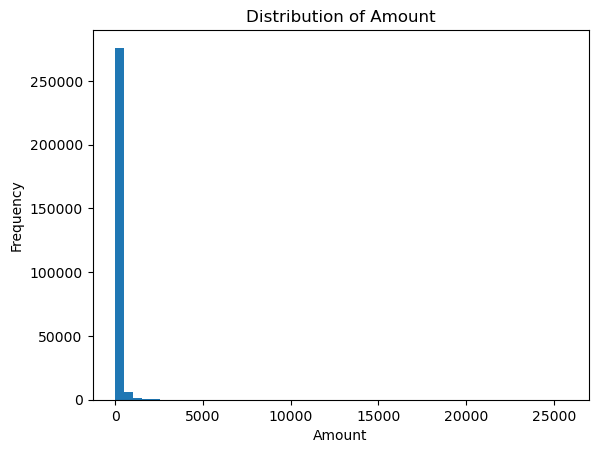

In [9]:
# Time distribution
plt.hist(df['Time'], bins=50)
plt.title("Distribution of Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.show()

# Amount distribution
plt.hist(df['Amount'], bins=50)
plt.title("Distribution of Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


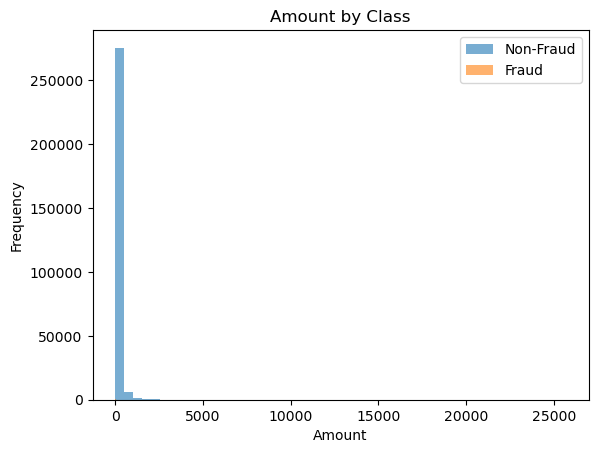

In [10]:
# Amount by Class
plt.hist(df.loc[df.Class==0, 'Amount'], bins=50, alpha=0.6, label="Non-Fraud")
plt.hist(df.loc[df.Class==1, 'Amount'], bins=50, alpha=0.6, label="Fraud")
plt.title("Amount by Class")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()


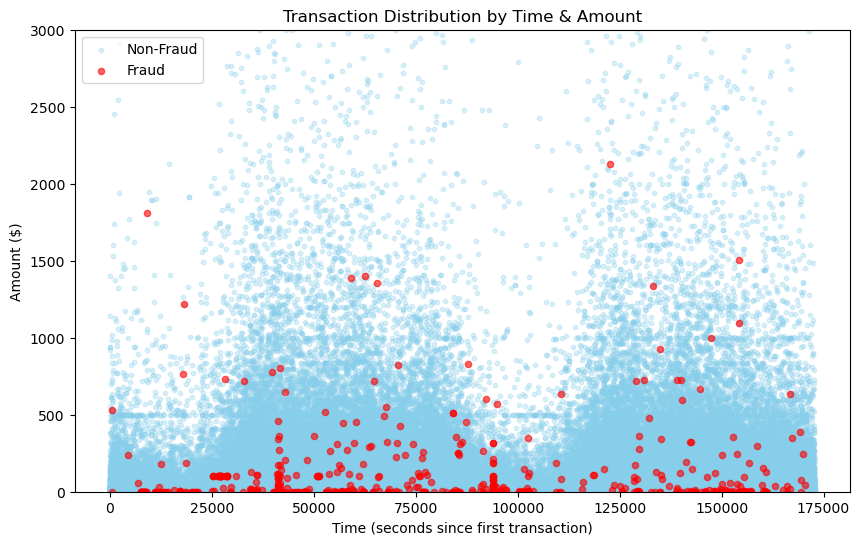

In [11]:
# Scatter plot: Time vs Amount by Class
plt.figure(figsize=(10,6))

# Non-fraud
plt.scatter(df[df['Class']==0]['Time'], 
            df[df['Class']==0]['Amount'], 
            c='skyblue', alpha=0.3, s=10, label="Non-Fraud")

# Fraud
plt.scatter(df[df['Class']==1]['Time'], 
            df[df['Class']==1]['Amount'], 
            c='red', alpha=0.6, s=20, label="Fraud")

plt.title("Transaction Distribution by Time & Amount")
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Amount ($)")
plt.legend()
plt.ylim(0, 3000)   # limit y-axis to see patterns (frauds are usually low amounts)
plt.show()


## 3. Data Preparation

In [12]:
# Features / Target
X = df.drop(columns=['Class'])
y = df['Class']

# Train-Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Fraud ratio in train:", y_train.mean())


Train shape: (227845, 30)  Test shape: (56962, 30)
Fraud ratio in train: 0.001729245759178389


In [13]:
# Scale only 'Time' and 'Amount'
scale_cols = ['Time', 'Amount']

preprocess = ColumnTransformer(
    transformers=[('scale_ta', StandardScaler(), scale_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False)


## 4. Model Development and Evaluation


===== Logistic Regression =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9600    0.9795     56864
           1     0.0360    0.8673    0.0691        98

    accuracy                         0.9598     56962
   macro avg     0.5179    0.9137    0.5243     56962
weighted avg     0.9981    0.9598    0.9779     56962

Confusion Matrix:
[[54587  2277]
 [   13    85]]
ROC-AUC: 0.9532


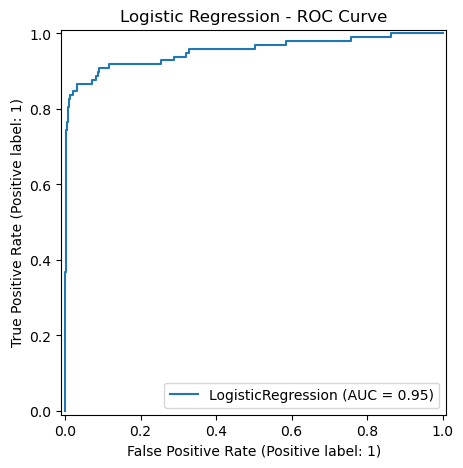


===== Random Forest =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9610    0.7551    0.8457        98

    accuracy                         0.9995     56962
   macro avg     0.9803    0.8775    0.9227     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion Matrix:
[[56861     3]
 [   24    74]]
ROC-AUC: 0.9572


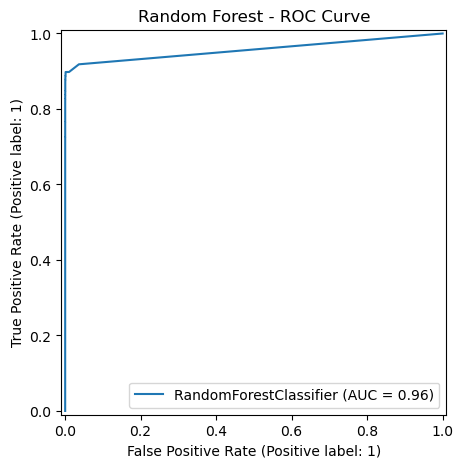


===== XGBoost =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8817    0.8367    0.8586        98

    accuracy                         0.9995     56962
   macro avg     0.9407    0.9183    0.9292     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion Matrix:
[[56853    11]
 [   16    82]]
ROC-AUC: 0.9653


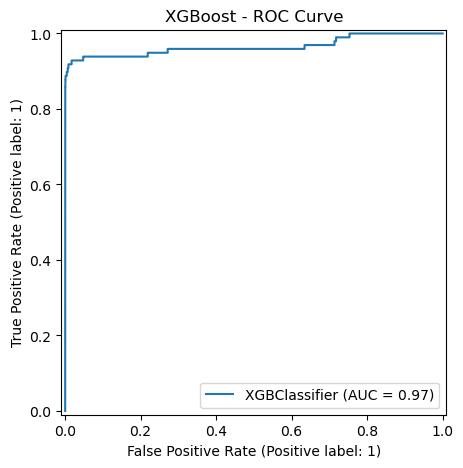

In [15]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=8000, solver="saga", class_weight="balanced", random_state=42)
log_reg.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=200, class_weight="balanced",random_state=42)
rf_clf.fit(X_train, y_train)

# XGBoost
xgb_clf = XGBClassifier(n_estimators=200, eval_metric="logloss",
                        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),random_state=42 )
xgb_clf.fit(X_train, y_train)

# Model Evaluation

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Reports
    print(f"\n===== {name} =====")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

    # Plots
    fig, ax = plt.subplots(figsize=(6, 5))  # just one axis
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    ax.set_title(f"{name} - ROC Curve")
    plt.show()

# Evaluate all models
evaluate_model("Logistic Regression", log_reg, X_test, y_test)
evaluate_model("Random Forest", rf_clf, X_test, y_test)
evaluate_model("XGBoost", xgb_clf, X_test, y_test)

